In [1]:
from src import data
from src import mlp

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

### Process Wave Data

In [2]:
# Buouy data paths for wave related measurements
DATA_PATH_2022 = 'data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = 'data/targetstation46240/46240h2021.txt'
DATA_PATH_2020 = 'data/targetstation46240/46240h2020.txt'
DATA_PATH_2019 = 'data/targetstation46240/46240h2019.txt'
DATA_PATH_2018 = 'data/targetstation46240/46240h2018.txt'
DATA_PATH_2017 = 'data/targetstation46240/46240h2017.txt'
DATA_PATH_2016 = 'data/targetstation46240/46240h2016.txt'
DATA_PATH_2015 = 'data/targetstation46240/46240h2015.txt'
DATA_PATH_2014 = 'data/targetstation46240/46240h2014.txt'
DATA_PATH_2013 = 'data/targetstation46240/46240h2013.txt'
DATA_PATH_2012 = 'data/targetstation46240/46240h2012.txt'
DATA_PATH_2011 = 'data/targetstation46240/46240h2011.txt'
DATA_PATH_2010 = 'data/targetstation46240/46240h2010.txt'
DATA_PATH_2009 = 'data/targetstation46240/46240h2009.txt'

In [3]:
file_paths = [DATA_PATH_2009,DATA_PATH_2010, DATA_PATH_2011, DATA_PATH_2012, DATA_PATH_2013, 
              DATA_PATH_2014, DATA_PATH_2015, DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, 
              DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]

station46240specs = ['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']

In [4]:
# Re-reading and combining data from all files with outliers replaced by NaN
all_wave_data_46240 = pd.concat([data.process_file_to_hourly_last(file) for file in file_paths])

all_wave_data_46240.drop(columns=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE', 'ATMP'], inplace=True)

In [5]:
all_wave_data_46240.shape

(116706, 9)

In [6]:
all_wave_data_46240[all_wave_data_46240.isnull().any(axis=1)]

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-04-06 23:00:00,2009,4,6,23,0.96,15.38,11.37,7.0,NaN
2009-04-07 00:00:00,2009,4,7,0,0.83,11.76,10.87,354.0,NaN
2009-04-08 01:00:00,2009,4,8,1,0.87,12.50,10.72,352.0,NaN
2009-04-08 02:00:00,2009,4,8,2,0.88,11.76,10.62,347.0,NaN
2009-04-08 03:00:00,2009,4,8,3,0.75,11.76,10.31,349.0,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-31 08:00:00,2022,8,31,8,0.20,NaN,5.65,NaN,15.7
2022-08-31 09:00:00,2022,8,31,9,0.21,NaN,5.84,NaN,15.6
2022-08-31 10:00:00,2022,8,31,10,0.23,NaN,5.85,NaN,15.6


In [7]:
# drop rows that contain NaN values
all_wave_data_46240.dropna(inplace=True)

In [8]:
all_wave_data_normalized = all_wave_data_46240.copy()

In [9]:
# normalize wave height seperately so we can save its scaler for later use
wvht_scaler = StandardScaler()
all_wave_data_normalized['WVHT'] = wvht_scaler.fit_transform(all_wave_data_normalized[['WVHT']])

In [10]:
# normalize the input data since our features are on different scales / units
columns_to_normalize = ['DPD', 'APD', 'MWD', 'WTMP']
scaler_other = StandardScaler()
all_wave_data_normalized[columns_to_normalize] = scaler_other.fit_transform(all_wave_data_normalized[columns_to_normalize])

In [11]:
all_wave_data_normalized.head()

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,0.385981,0.083302,-0.002309,0.326864,-1.218022
2009-01-01 01:00:00,2009,1,1,1,0.154898,-0.371289,-0.860774,0.246659,-1.218022
2009-01-01 02:00:00,2009,1,1,2,0.270439,-0.156929,-1.236353,0.326864,-1.218022
2009-01-01 03:00:00,2009,1,1,3,0.432197,0.083302,-1.338295,0.326864,-1.218022
2009-01-01 04:00:00,2009,1,1,4,0.108682,0.663551,-1.214891,0.420437,-1.218022


### Splitting Data

Note: since the missing indices are the same across normalized and un-normalized datasets, we can use the same missing indices.

In [72]:
train_df = all_wave_data_46240[all_wave_data_46240.index.year <= 2018]
val_df = all_wave_data_46240[(all_wave_data_46240.index.year == 2019) | (all_wave_data_46240.index.year == 2020) | (all_wave_data_46240.index.year == 2021)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_df = all_wave_data_46240[(all_wave_data_46240.index.year == 2022)]

In [77]:
train_normalized_df = all_wave_data_normalized[all_wave_data_normalized.index.year <= 2018]
val_normalized_df = all_wave_data_normalized[(all_wave_data_normalized.index.year == 2019) | (all_wave_data_normalized.index.year == 2020) | (all_wave_data_46240.index.year == 2021)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_normalized_df = all_wave_data_normalized[(all_wave_data_normalized.index.year == 2022)]

In [78]:
missing_indices_train = data.check_for_missing_rows(train_normalized_df)
len(missing_indices_train)

614

In [79]:
missing_indices_val = data.check_for_missing_rows(val_normalized_df)
len(missing_indices_val)

60

In [80]:
missing_indices_test = data.check_for_missing_rows(test_normalized_df)
len(missing_indices_test)

5

### Training MLP Models

Adding a simple helper function for plotting to clean up the notebook.

In [93]:
def plot_predicted_vs_actual(model,
                             X_val,
                             y_val,
                             scaler=None,
                             title='Actual vs Predicted Values',
                             N=1000):
    model.eval()

    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val).float()
        y_val_tensor = torch.tensor(y_val).float()
        
        predictions = model(X_val_tensor)

        # Convert predictions and actual values to numpy arrays
        predictions_np = predictions.numpy().reshape(-1, 1)  # Reshape for scaler
        y_val_np = y_val_tensor.numpy().reshape(-1, 1)       # Reshape for scaler
        
        # Unscale predictions and actual values
        if scaler:
            predictions_unscaled = scaler.inverse_transform(predictions_np).flatten()
            y_val_unscaled = scaler.inverse_transform(y_val_np).flatten()
        else:
            predictions_unscaled = predictions_np.flatten()
            y_val_unscaled = y_val_np.flatten()

        
    plt.figure(figsize=(15, 5))
    plt.plot(y_val_unscaled[:N], label='Actual')
    plt.plot(predictions_unscaled[:N], label='Predicted')
    plt.title(title)
    plt.xlabel('Sample index')
    plt.ylabel('Wave Height (meters)')
    plt.legend()
    plt.show()

#### MLP 1

We use the following paramters for building our dataset:
- window: 48
- step: 1
- lead: 12
- features: 

We use the follow hyperparamters for model training:
- learning rate: 1e-4
- weight_decay: 1e-4
- dropout: 0.1
- epochs: 50

In [88]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_normalized_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT'],
                                                          window=48,
                                                          step=1,
                                                          lead=12)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (65934, 48) y_train shape: (65934,)


In [89]:
X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_normalized_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT'],
                                                      window=48,
                                                      step=1,
                                                      lead=12)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (22632, 48) y_val shape: (22632,)


Epoch: 1/50 - Train Loss: 0.6504 - Val Loss: 0.4341
Epoch: 10/50 - Train Loss: 0.4215 - Val Loss: 0.3613
Epoch: 20/50 - Train Loss: 0.4127 - Val Loss: 0.3562
Epoch: 30/50 - Train Loss: 0.4083 - Val Loss: 0.3543
Epoch: 40/50 - Train Loss: 0.4053 - Val Loss: 0.3535
Epoch: 50/50 - Train Loss: 0.4049 - Val Loss: 0.3531


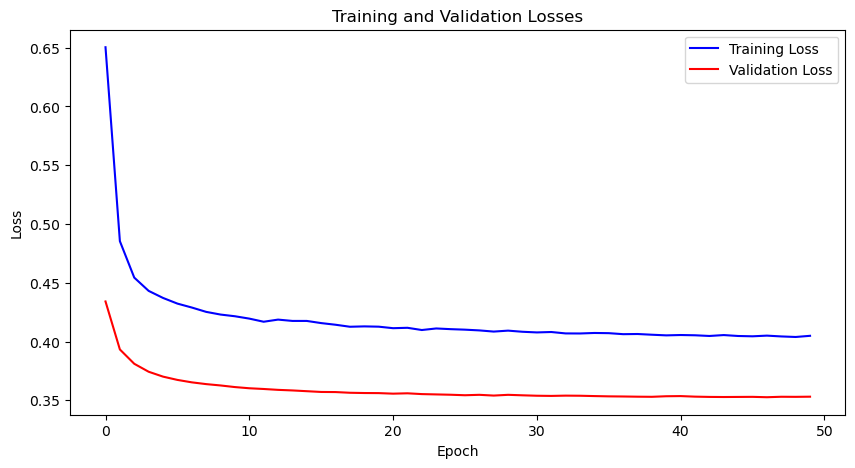

In [91]:
model = mlp.WaveForecastMLP(input_dim=48, dropout_rate=0.1)

train_loader = mlp.build_dataloader_from_np(X_train, y_train, batch_size=64, shuffle=False)
val_laoder = mlp.build_dataloader_from_np(X_val, y_val, batch_size=64, shuffle=False)

criterion = torch.nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) 

mlp.train(model=model,
          train_loader=train_loader,
          val_loader=val_laoder,
          criterion=criterion,
          optimizer=optimizer,
          n_epochs=50)

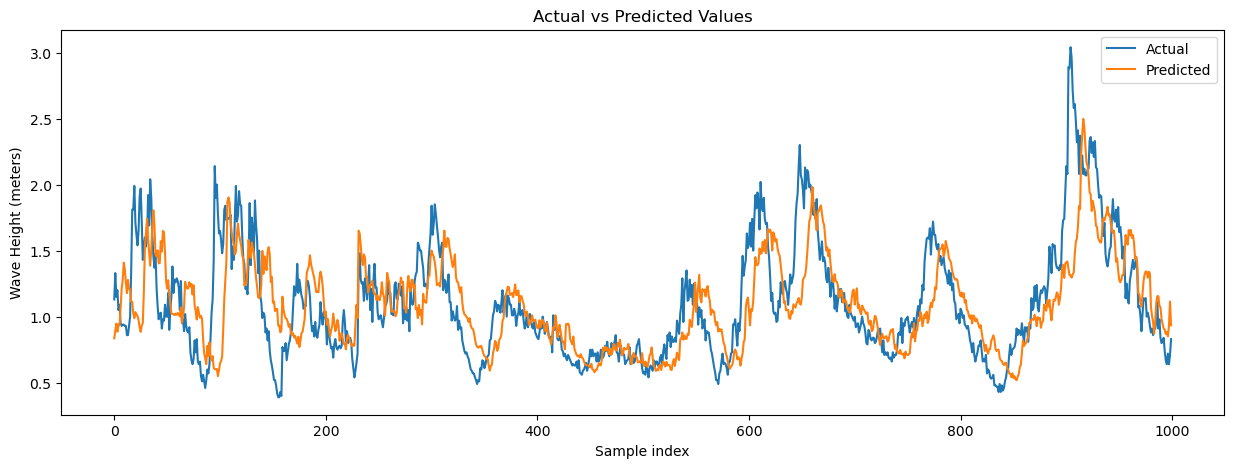

In [94]:

plot_predicted_vs_actual(model, X_val, y_val, scaler=wvht_scaler, N=1000)

#### MLP 2

We use the following paramters for building our dataset:
- window = 12
- step = 6
- lead = 12

We use the follow hyperparamters for model training:
- learning rate: 1e-4
- weight_decay: 1e-5
- epochs: 50

In [43]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_normalized_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=24,
                                                          step=4,
                                                          lead=24)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (72071, 120) y_train shape: (72071,)


In [44]:
X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_normalized_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                      window=24,
                                                      step=4,
                                                      lead=24)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (15707, 120) y_val shape: (15707,)


Epoch: 1/40 - Train Loss: 0.8832 - Val Loss: 0.6397
Epoch: 10/40 - Train Loss: 0.6651 - Val Loss: 0.5645
Epoch: 20/40 - Train Loss: 0.6401 - Val Loss: 0.5590
Epoch: 30/40 - Train Loss: 0.6287 - Val Loss: 0.5575
Epoch: 40/40 - Train Loss: 0.6209 - Val Loss: 0.5588


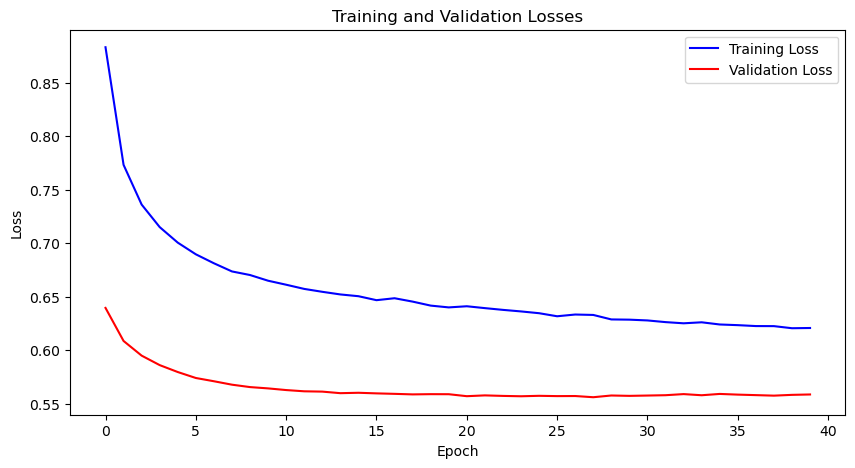

In [45]:
model = mlp.WaveForecastMLP(input_dim=24*5, dropout_rate=0.3)

train_loader = mlp.build_dataloader_from_np(X_train, y_train, batch_size=64, shuffle=False)
val_laoder = mlp.build_dataloader_from_np(X_val, y_val, batch_size=64, shuffle=False)

criterion = torch.nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) 

mlp.train(model=model,
          train_loader=train_loader,
          val_loader=val_laoder,
          criterion=criterion,
          optimizer=optimizer,
          n_epochs=40)

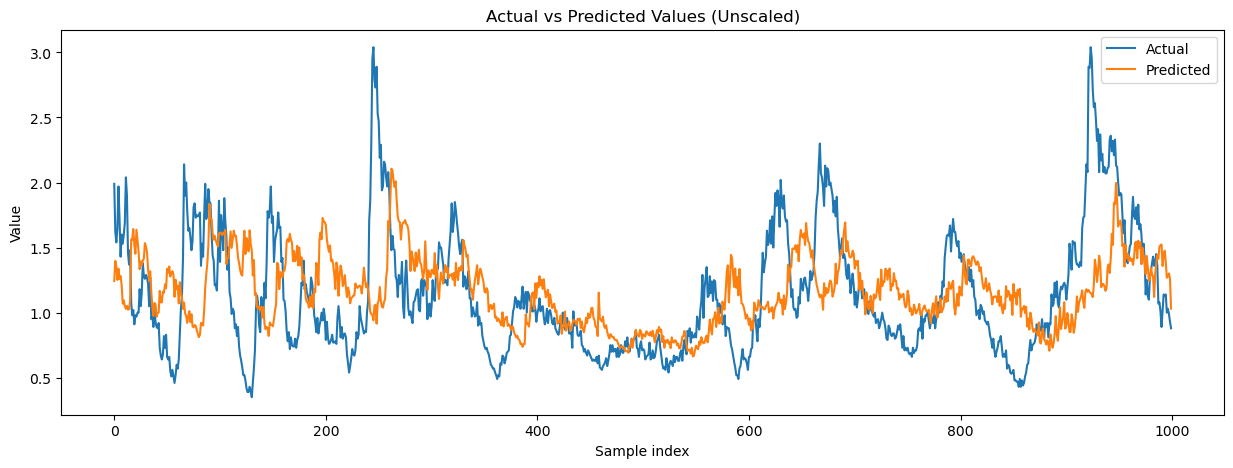

In [46]:
plot_predicted_vs_actual(model, X_val, y_val, scaler=wvht_scaler, N=1000)

#### MLP 3

We use the following paramters for building our dataset:
- window = 24
- step = 4
- lead = 12

We use the follow hyperparamters for model training:
- learning rate: 1e-4
- weight decay: 1e-5
- epochs: 50

From MLP 1, we noticed some slight overfitting on the training set, so we added weight decay to out optimizer. We also increased the window (number of hourly measurements) to 24 that are spaced 6 hour apart instead of 4.

In [47]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                          window=24,
                                                          step = 4,
                                                          lead=24)


print(f'X_train shape: {X_train.shape} y_val shape: {y_train.shape}')

X_train shape: (63827, 120) y_val shape: (63827,)


In [48]:
X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD', 'WTMP'],
                                                      window=24,
                                                      step=4,
                                                      lead=24)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (24418, 120) y_val shape: (24418,)


Epoch: 1/50 - Train Loss: 7.3346 - Val Loss: 0.4597
Epoch: 10/50 - Train Loss: 0.2338 - Val Loss: 0.2115
Epoch: 20/50 - Train Loss: 0.2047 - Val Loss: 0.1909
Epoch: 30/50 - Train Loss: 0.1888 - Val Loss: 0.1717
Epoch: 40/50 - Train Loss: 0.1783 - Val Loss: 0.1606
Epoch: 50/50 - Train Loss: 0.1714 - Val Loss: 0.1538


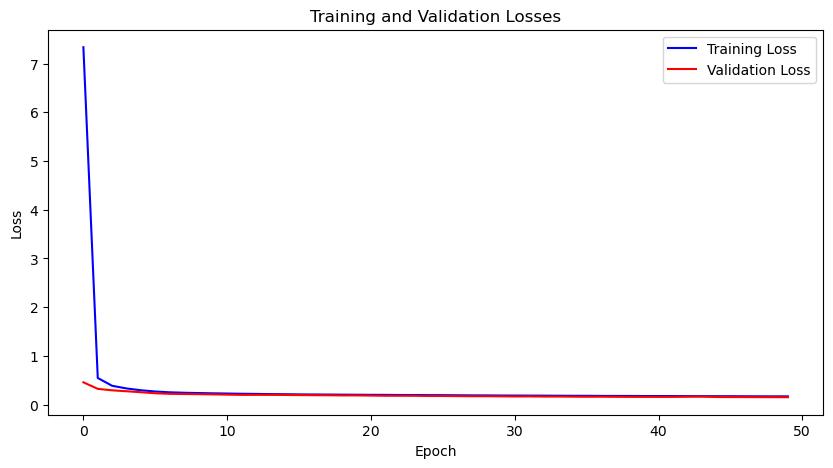

In [53]:
model = mlp.WaveForecastMLP(input_dim=24*5, dropout_rate=0.3)

train_loader = mlp.build_dataloader_from_np(X_train, y_train, batch_size=64, shuffle=False)
val_laoder = mlp.build_dataloader_from_np(X_val, y_val, batch_size=64, shuffle=False)

criterion = torch.nn.MSELoss()  # Mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # added in weight regularization

mlp.train(model=model,
          train_loader=train_loader,
          val_loader=val_laoder,
          criterion=criterion,
          optimizer=optimizer,
          n_epochs=50)

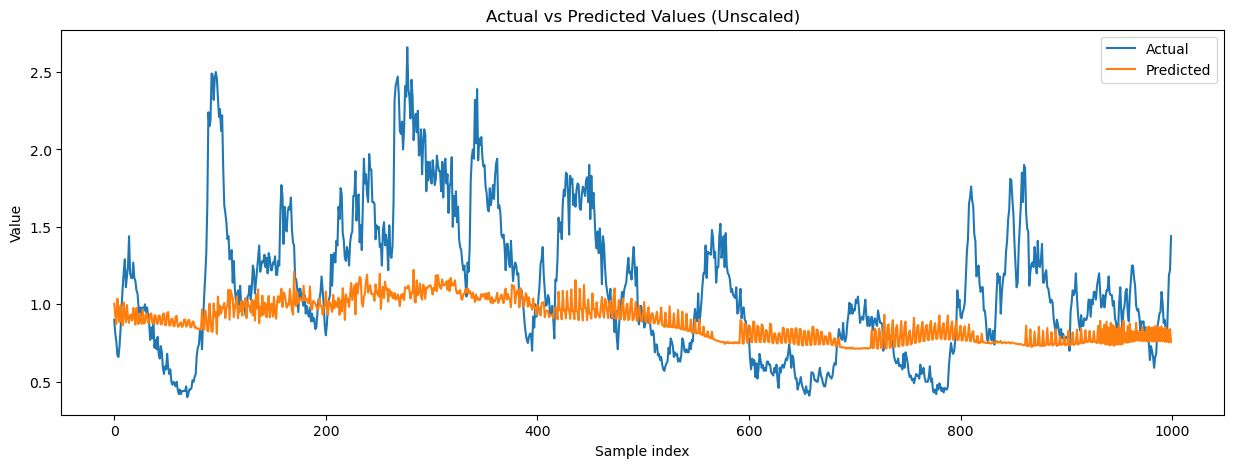

In [54]:
plot_predicted_vs_actual(model, X_val, y_val, N=1000)